iter:100 training loss: 0.40901005268096924, val loss: 0.4149837791919708
iter:200 training loss: 0.2813495695590973, val loss: 0.27194762229919434
iter:300 training loss: 0.20440241694450378, val loss: 0.2036176323890686
iter:400 training loss: 0.1528485268354416, val loss: 0.16457849740982056
iter:500 training loss: 0.14470617473125458, val loss: 0.14949822425842285
iter:600 training loss: 0.1169661432504654, val loss: 0.11863810569047928
iter:700 training loss: 0.11649281531572342, val loss: 0.11891971528530121
iter:800 training loss: 0.11213523149490356, val loss: 0.10668999701738358
iter:900 training loss: 0.09603536128997803, val loss: 0.09811557829380035
iter:1000 training loss: 0.09051326662302017, val loss: 0.0975094735622406
iter:1100 training loss: 0.09673171490430832, val loss: 0.09062492102384567
iter:1200 training loss: 0.0799732431769371, val loss: 0.08466492593288422
iter:1300 training loss: 0.0833178237080574, val loss: 0.08187399804592133
iter:1400 training loss: 0.08

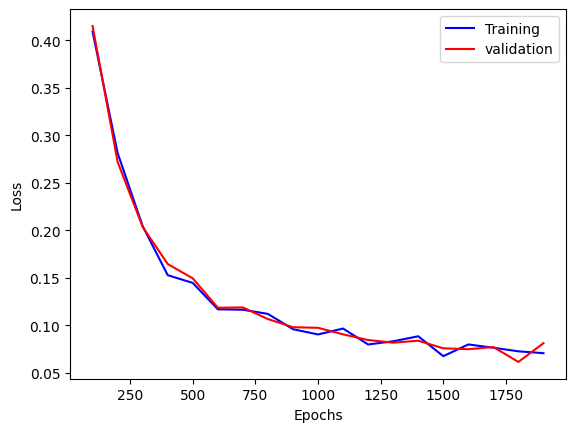

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from utils import *

def sample_data(split = 'train'):
    if split == 'train':
        data =  training_dataset
    else:
        data = validation_dataset
    
    ix = torch.randperm(data.shape[0])[:batch_size]
    
    return data[ix]

learning_rate = 0.01
max_iters = 2000
batch_size = 32

iters = []
loss_value = []
val_loss_value = []

dataset = torch.load("data/hidden.pt")
dataset_size = dataset.shape[0]
training_dataset = dataset[:int(dataset_size*0.5)]
validation_dataset = dataset[int(dataset_size*0.5):]
model = SAE(SAE_Config())

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = SAE(SAE_Config())
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X= sample_data()
        _, loss,_ = model(X)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V = sample_data(split= 'val')
                _, val_loss, _ = model(X_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()



        






In [8]:


_, _, hidden = model(training_dataset)
print("Non zero entries",(hidden>0).sum(-1).float().mean())


Non zero entries tensor(4.4314)


In [9]:
print((hidden>0).sum(0))
print(hidden.shape)
print(hidden.max())

tensor([     0,      0,      0,      0,      0,      0, 135285,      0,      0,
             0,      0,      0, 124717,      0,      0,  38441, 136386,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0, 114318,   4541,      2,
             1,      2, 144456,      0,      0,      0,      0,      0,      3,
             0,      0,      0,  27889,      0])
torch.Size([163840, 50])
tensor(0.1854, grad_fn=<MaxBackward1>)


In [14]:
sp = SuperpositionModel()
PATH = "models/superpositon.pt"
sp.load_state_dict(torch.load(PATH))
print(sp.eval())
original_data  = torch.load("data/original.pt")
print(original_data.shape)

SuperpositionModel(
  (encoder): Linear(in_features=5, out_features=5, bias=False)
  (decoder): Linear(in_features=5, out_features=5, bias=True)
  (relu): ReLU()
)
torch.Size([327680, 5])


In [15]:
logits, loss, hidden = sp(original_data, original_data)
_,_, latents = model(hidden)
print(hidden.shape, loss, latents.shape, original_data.shape)

torch.Size([327680, 5]) tensor(7.3472e-09, grad_fn=<MeanBackward0>) torch.Size([327680, 50]) torch.Size([327680, 5])


In [16]:
freqs = (latents>0).sum(0)
print(freqs)

tensor([     0,      0,      0,      0,      0,      0, 270610,      0,      0,
             0,      0,      0, 249389,      0,      0,  76925, 272740,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0, 228564,   9088,      2,
             1,      4, 288889,      0,      0,      0,      0,      0,      5,
             0,      0,      0,  55729,      0])


In [17]:
for i in range(50):
   indices = latents[:, i] > 0.01
   x =  original_data[indices]
   _, loss, _ = sp(x, x)
   if freqs[i] and loss.item():
      print(i, loss.item(), freqs[i].item())

   

6 7.189707051935557e-09 270610
12 7.230460230545077e-09 249389
15 8.164324327708528e-09 76925
16 7.097151311086236e-09 272740
33 7.243143862467605e-09 228564
34 1.0882441614512572e-08 9088
35 nan 2
36 nan 1
37 nan 4
38 7.114191014068183e-09 288889
44 nan 5
48 8.438784782072162e-09 55729


In [18]:
for i in range(20):
   indices = original_data[:, i] > 0
   x =  original_data[indices]
   _, loss, _ = sp(x, x)
   if loss.item():
      print(i, loss.item(), indices.shape[0])


0 7.3202857109322395e-09 327680
1 7.319266082106424e-09 327680
2 7.319021833041006e-09 327680
3 7.318897932151458e-09 327680
4 7.319730599419927e-09 327680


IndexError: index 5 is out of bounds for dimension 1 with size 5

In [19]:



get_reconstructed_loss(sp, model, original_data)

reconstructed loss 0.11458352953195572, original 7.347201069762832e-09. Percentage 93.06351470947266%


In [20]:
point = original_data[0]
print(point)

tensor([0.4581, 0.4829, 0.3125, 0.0000, 0.2139])


In [21]:
sp(point, point)

(tensor([4.5809e-01, 4.8286e-01, 3.1255e-01, 1.4607e-04, 2.1403e-01],
        grad_fn=<ReluBackward0>),
 tensor(6.2588e-09, grad_fn=<MeanBackward0>),
 tensor([-0.3117, -0.2383,  0.3822, -0.5265, -0.0953],
        grad_fn=<SqueezeBackward4>))

In [22]:
sp(point, point, sae = model)

(tensor([0.2066, 0.0670, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>),
 tensor(0.0759, grad_fn=<MeanBackward0>),
 tensor([-0.4751, -0.0215, -0.0399,  0.0971,  0.0534], grad_fn=<ViewBackward0>))